In [4]:
import h5py
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy import uint32, uint64, float64, float32, linspace, array, logspace, sin, cos, pi, arange
from scipy.interpolate import griddata, NearestNDInterpolator
from matplotlib import figure
import matplotlib.colors as colors
import matplotlib.patches as patches
import cmasher as cmr
from astropy.io import fits
#from sklearn.cluster import DBSCAN
import pandas as pd
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
import gc
gc.enable()

#import arepy

#%matplotlib inline



In [8]:
### constants: 
kb = 1.38e-23
kb_cgs = 1.38e-16
mH = 1.67e-24
mu = 2.8
h = 6.626e-34
h_cgs = 6.62e-27
gamma = 5./3.
pc2cm = 3.086e18
msun2g = 2e33

arepoLength = 3.0856e20
arepoMass = 1.991e33
arepoVel = 1.0e5

arepoTime = arepoLength/arepoVel
arepoDensity = arepoMass/arepoLength/arepoLength/arepoLength
arepoEnergy= arepoMass*arepoVel*arepoVel
arepoColumnDensity = arepoMass/arepoLength/arepoLength

def rotate(x,y,theta):
    xprime = x*cos(theta) - y*sin(theta)
    yprime = x*sin(theta) + y*cos(theta)
    return xprime, yprime

def chunk_counting(a):
    #chunk counting (a=[3,2,5] ---> returns [0,1,2, 0,1, 0,1,2,3,4])

    csum = np.cumsum(a)[0:-1]
    csum = np.insert(csum, 0, 0)

    r_csum = np.repeat(csum, a)

    return np.arange(r_csum.size) - r_csum

def find_a_in_b(a, b):
    orig_indices = b.argsort() #this is the most expensive part, especially if b is very large
    b = b[orig_indices]
    
    unique_b, index_start, count = np.unique(b, return_counts=True, return_index=True)
    
    ind = np.searchsorted(unique_b, a)
    
    ind_start = index_start[ind]
    ind_count = count[ind]
    
    ind2 = np.repeat(ind_start, ind_count) + chunk_counting(ind_count)
    
    ind2 = orig_indices[ind2]
    return ind2

### LV diagram
def XYZ2lbr(X,Y,Z):
    r = np.sqrt(X**2+Y**2+Z**2)
    l = np.arctan2(Y,X)
    b = pi/2 - np.arccos(Z/r)
    return l,b,r

def lbr2XYZ(l,b,r):
    X = r*sin(b+pi/2)*cos(l)
    Y = r*sin(b+pi/2)*sin(l)
    Z = r*cos(b+pi/2)
    return X,Y,Z

def xyz2XYZ(x,y,z,R0=80.0):
    return x+R0,y,z

def XYZ2xyz(X,Y,Z,R0=80.0):
    return X-R0,Y,Z

def xyz2lbr(x,y,z):
    X,Y,Z = xyz2XYZ(x,y,z)
    l,b,r = XYZ2lbr(X,Y,Z)
    return l,b,r

def lbr2xyz(l,b,r):
    X,Y,Z = lbr2XYZ(l,b,r)
    x,y,z = XYZ2xyz(X,Y,Z)
    return x,y,z

def vxyz2vlbr(x,y,z,vx,vy,vz,vsun=220.0):
    # see wiki "vector fields in spherical coords" for formulas
    X,Y,Z = xyz2XYZ(x,y,z)
    l,b,r = XYZ2lbr(X,Y,Z)
    rhat = [sin(b+pi/2)*cos(l),sin(b+pi/2)*sin(l),cos(b+pi/2)]
    bhat = [cos(b+pi/2)*cos(l),cos(b+pi/2)*sin(l),-sin(b+pi/2)] 
    lhat = [-sin(l),cos(l),0]
    vr = vx*rhat[0] + (vy-vsun)*rhat[1] + vz*rhat[2]
    vb = vx*bhat[0] + (vy-vsun)*bhat[1] + vz*bhat[2]
    vl = vx*lhat[0] + (vy-vsun)*lhat[1]
    return l,b,r,vl,vb,vr

def read_snapshot_file(filename):
    header = {}
    data = {}

    f = h5py.File(filename, 'r')

    for item in f['Header'].attrs:
        header[item] = f['Header'].attrs[item]

    for item in f['PartType0'].keys():
        data[item] = f['PartType0'][item][:]

    data['Stars'] = {}
    for item in f['PartType4'].keys():
        data['Stars'][item] = f['PartType4'][item][:]
        
    f.close()
    del f
    gc.collect()

    return data, header

    

In [12]:
snap_dir = '../SIMS/snapshots/sp_debug_04/'
snap_i = 'whole_disk_509.hdf5'


filename = snap_dir+snap_i
data_chem, header_chem = read_snapshot_file(snap_dir+snap_i)

In [163]:
#### interpolation for Chemical snapshot
### grab snap timestamp
t_chem = header_chem['Time']
BoxSize = header_chem['BoxSize']

### grab x,y,z
x_chem,y_chem,z_chem=np.array(data_chem['Coordinates']).T

### center galaxy on
x_chem,y_chem,z_chem = x_chem-BoxSize/2., y_chem-BoxSize/2., z_chem-BoxSize/2.

### rotate to bar frame
omega=4.0
phi_chem = np.radians(-5+omega*t_chem) #-60
x_chem,y_chem = rotate(x_chem,y_chem,phi_chem)

rho_chem = np.array(data_chem['ChemicalAbundances'])
rho_chem_HII = rho_chem[:,2]

### stack points
points_chem = np.vstack((x_chem,y_chem,z_chem)).T

rhof_chem_HII = NearestNDInterpolator(points_chem,rho_chem_HII)


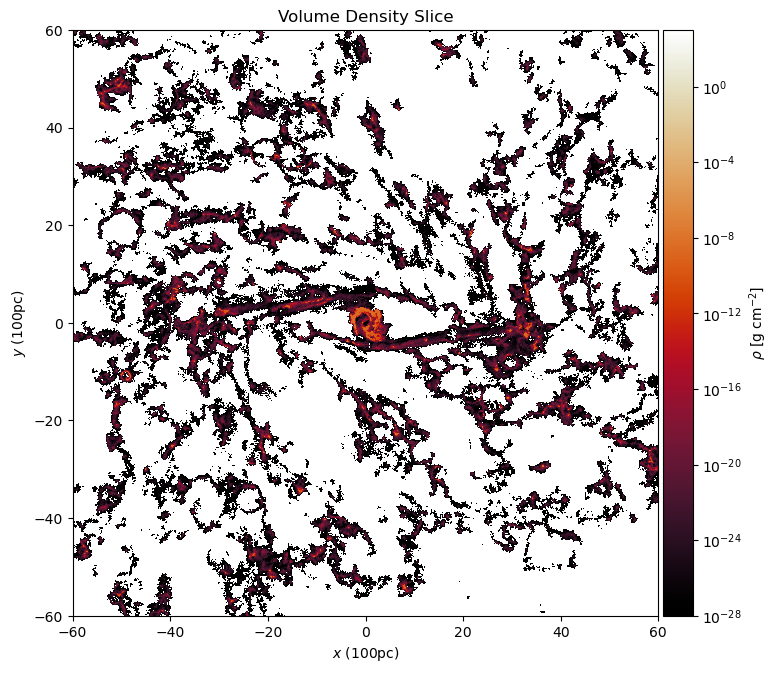

<Figure size 640x480 with 0 Axes>

In [172]:
### define grid size
Nx, Ny, Nz = 601, 601, 11
### define the radial extent of the plot
plotrange=60
zslice=5
xgrid, ygrid, zgrid=linspace(-1*plotrange,1*plotrange,Nx),linspace(-plotrange,plotrange,Ny),linspace(-10,10,Nz)

XGRID,YGRID,ZGRID = np.meshgrid(xgrid,ygrid,zgrid)
fig, ax = plt.subplots(1,1,figsize=(8,10),facecolor='white')
### do the actual interpolation
RHO = rhof_chem_HII(XGRID,YGRID,ZGRID)
u = 1.0
extent = (xgrid.min()/u,xgrid.max()/u,ygrid.min()/u,ygrid.max()/u)

### set dynamic range
powmax,powmin = 3,-28

levels = logspace(powmin,powmax,256)
### use range to create a normalization scheme
norm = colors.LogNorm(vmin=10**powmin, vmax=10**powmax)

im = ax.imshow(RHO[:,:,zslice],norm=norm,extent=extent,cmap=cmr.sunburst,interpolation='nearest',origin='lower')

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, ax=ax,label='$\\rho$ [g cm$^{-2}$]', cax=cbar)




ax.set_xlabel(r'$x$ (100pc)')
ax.set_ylabel(r'$y$ (100pc)')
ax.set_xlim(xgrid.min(),xgrid.max())
ax.set_ylim(ygrid.min(),ygrid.max())
ax.set_title("Volume Density Slice")

plt.show()
plt.clf()



In [173]:
RHO_flat = np.reshape(RHO[:,:,zslice], RHO[:,:,zslice].size)
x_flat   = np.reshape(XGRID[:,:,zslice], XGRID[:,:,zslice].size)
y_flat   = np.reshape(YGRID[:,:,zslice], YGRID[:,:,zslice].size)

In [174]:
###Make empty list to start the hist addition
Nh = 601
hist = np.zeros((Nh-1,Nh-1))

Text(0, 0.5, '$y$ (100pc)')

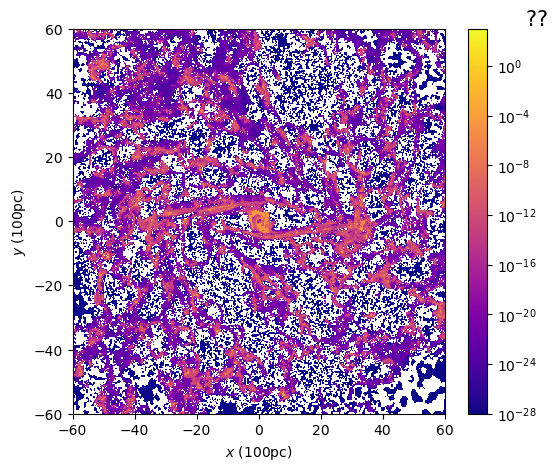

In [179]:
x_bins = np.linspace(x_flat.min(),x_flat.max(), Nh)
y_bins = np.linspace(y_flat.min(),y_flat.max(), Nh)

fig, ax1 = plt.subplots(1, 1, figsize=(6,5))

hist_i=ax1.hist2d(x_flat, y_flat, bins = [x_bins, y_bins], 
            weights = RHO_flat, norm=norm, cmap='plasma') 
clb = fig.colorbar(hist_i[3] , ax=ax1 )
clb.set_label(label = r'$??$', labelpad=0, y=1.05, rotation=0, fontsize = 15)
ax.set_aspect('equal')


ax1.set_xlabel(r'$x$ (100pc)')
ax1.set_ylabel(r'$y$ (100pc)')

In [148]:
hist += hist_i[0] 